In [2]:
example_topic = "Impact of millon-plus token context window language models on RAG"

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

fast_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.0,)
long_context_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    temperature=0.0)

gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentionde below. Please identify and recomend some Wikipedia pagens on clasely related topics
    
    Please list the as many subject and urls as you can
    
    Topic of interest: {topic}"""
)

class RelatedSubject(BaseModel):
    topics: List[str] = Field(
    description="Comprehensive list of related subjects as background research",
    )

expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(RelatedSubject)

related_subjects = await expand_chain.ainvoke({'topic': example_topic})
related_subjects

RelatedSubject(topics=['Large language models', 'Retrieval augmented generation', 'Context window', 'Natural language processing', 'Artificial intelligence', 'Machine learning', 'Deep learning', 'Transformer networks', 'Wikipedia'])

In [5]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\nRelated: {related}\n\n"[:max_length]

def format_docs(docs):
    return "\n\n".join([format_doc(doc) for doc in docs])


class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor"
    )
    name: str = Field(
        description="Name of the editor",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic."
    )
    description: str = Field(
        description="Description of the editor's focus, concers, and motives`"
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}"
    
class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="List of editors with their perspectives on the topic"
    )

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You need to select a diverse(and distinc) group of Wikipedia editors who will work together to create a comprehensive article on the topic.
         You can use other Wikipedia pages of related topics for inspiration. For each editor, add description of what they will focus on.
         
         Wiki page outlines of related topics for inspiration: 
         {examples}"""),
         ("user","Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatGoogleGenerativeAI(model='gemini-2.0-flash').with_structured_output(Perspectives)

@as_runnable
async def survey_subjects(topics: str):
    reletaed_subjects = await expand_chain.ainvoke({'topic': topics})
    retrieved_docs = await wikipedia_retriever.abatch(reletaed_subjects.topics, return_exceptions=True)
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({
        "examples": formatted,
        "topic": topics
    })

perspectives = await survey_subjects.ainvoke(example_topic)
perspectives.dict()

C:\Users\Admin\AppData\Local\Temp\ipykernel_3988\833876501.py:66: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  perspectives.dict()


{'editors': [{'affiliation': 'Independent AI Researcher',
   'name': 'Dr. Anya Sharma',
   'role': 'Technical Expert',
   'description': 'Focuses on the technical aspects of RAG, including indexing strategies, retrieval algorithms, and prompt engineering techniques optimized for large context windows.'},
  {'affiliation': 'Enterprise Solutions Architect',
   'name': 'Ben Carter',
   'role': 'Industry Application',
   'description': 'Concerned with the practical applications of large context RAG in enterprise settings, focusing on scalability, security, and integration with existing systems.'},
  {'affiliation': 'AI Ethics Advocate',
   'name': 'Dr. Sofia Rodriguez',
   'role': 'Ethics and Bias',
   'description': 'Examines the ethical implications of using large context RAG, including potential biases in retrieved information and the impact on transparency and accountability.'},
  {'affiliation': 'Computational Linguist',
   'name': 'Dr. Kenji Tanaka',
   'role': 'Linguistic Analysis',

In [6]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage, BaseMessage, HumanMessage, ToolMessage
from typing import Annotated, Sequence
from langchain_core.prompts import MessagesPlaceholder

def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left+right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]


gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

def tag_with_name(ai_message: AIMessage, name:str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude=("type")))
        converted.append(message)
    return {'messages': converted}


@as_runnable
async def generate_question(state:InterviewState):
    editor = state['editor']
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}


print(perspectives.editors[0])

messages = [
    HumanMessage(f"So you said you were wrting an article on {example_topic}")
]

question = await generate_question.ainvoke(
    {'editor':perspectives.editors[0],
     "messages":messages}
)

question['messages'][0].content

affiliation='Independent AI Researcher' name='Dr. Anya Sharma' role='Technical Expert' description='Focuses on the technical aspects of RAG, including indexing strategies, retrieval algorithms, and prompt engineering techniques optimized for large context windows.'


"Hello Dr. Sharma, it's a pleasure to speak with you.  My name is Alex, and I'm a Wikipedia editor working on an article about the impact of million-plus token context window language models on Retrieval Augmented Generation (RAG).  My focus is on the practical implications and limitations of these models for real-world applications.  My first question is: what are some of the most significant challenges you've encountered in indexing and retrieving information for these extremely long context windows, beyond the obvious computational constraints?"

## Expert

In [7]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questons."

    )

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            "You are a helpful research assistant. Query the search engine to answer the user's questions."
        ),
        MessagesPlaceholder(variable_name="messages", optional=True)
    ]
)
gen_queries_chain = gen_queries_prompt | ChatGoogleGenerativeAI(model="gemini-2.0-flash").with_structured_output(Queries, include_raw=True)

queries = await gen_queries_chain.ainvoke({
    'messages': [HumanMessage(content=question['messages'][0].content)]
})
print(f"Queries: {queries['parsed'].queries}")

Queries: ['challenges indexing and retrieving information million-plus token context window language models', 'limitations of million-plus token context window language models for real-world applications', 'practical implications of million-plus token context window language models for Retrieval Augmented Generation (RAG)']


In [8]:
import json
from langchain_core.runnables import RunnableConfig

class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations."
    )
    cited_urls:List[str] = Field(
        description="List of urls cited in the answer"
    )
    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls))
    

gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(rum_name="GenerateAnswer")
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_search = TavilySearchResults(max_results=4)

@tool
async def search_engine(query:str):
    """Search engine to the internet"""
    results = tavily_search.invoke(query)
    return [{'content': r['content'], "url": r["url"]} for r in results]


async def gen_answer(
        state: InterviewState,
        config: Optional[RunnableConfig] =None,
        name: str = "Subject Matter Expert",
        max_str_len: int = 15000
):
    
    swapped_state = swap_roles(state, name)
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_result = await search_engine.abatch(
        queries['parsed'].queries, config, return_exceptions=True
    )
    successfull_result = [
        res for res in query_result if not isinstance(res, Exception)
        ]
    all_query_results = {
        res['url']: res['content'] for results in successfull_result for res in results
    }
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].tool_calls[0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state['messages'].extend([ai_message, tool_message])

    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)
    cited_references = {k:v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)
    return {"messages": [formatted_message], "references": cited_references}


example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question['messages'][0].content)]},
)


example_answer['messages'][-1].content

C:\Users\Admin\AppData\Local\Temp\ipykernel_3988\2637305348.py:36: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=4)


'The most significant challenges in indexing and retrieving information for million-plus token context window language models, beyond computational constraints, include the difficulty of maintaining focus and identifying key information within the vast context, a phenomenon sometimes referred to as the “lost in the middle” problem.  Furthermore, model performance can degrade as the context window approaches its limits, even before the theoretical maximum is reached.  This degradation is often more pronounced than expected, and the effective utilization of all the information within the massive context window remains an open challenge.  Finally, the increased complexity of managing and processing such large contexts introduces new challenges in ensuring accuracy and efficiency, requiring innovative techniques to optimize resource usage and reduce latency.\n\nCitations:\n\n[1]: https://aiagentslist.com/blog/is-rag-still-relevant-with-million-tokens-llms\n[2]: https://blog.ayraa.io/rag-is

In [9]:
max_num_turns = 5



def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

In [10]:
final_step = None
initial_state = {
    "editor": perspectives.editors[0],
    "messages": [AIMessage(
        content=f"So you said you were writing an article on {example_topic}?",
        name="Subject Matter Expert"
    )]
}

async for step in interview_graph.astream(initial_state):
    name=next(iter(step))
    # print(step)
    print("-- ", step)
    final_step = step
    

final_state = next(iter(final_step.values()))

--  {'ask_question': {'messages': [AIMessage(content="Hello Dr. Sharma, it's a pleasure to speak with you.  My Wikipedia article focuses on the impact of million-plus token context window language models on Retrieval Augmented Generation (RAG) systems.  My first question is: what are the most significant challenges currently faced in indexing and retrieving information for these models, given their vastly expanded context windows?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, name='Dr. Anya Sharma', id='run--f54badac-099e-40ff-aa4d-80f8603d4e9d-0', usage_metadata={'input_tokens': 204, 'output_tokens': 72, 'total_tokens': 276, 'input_token_details': {'cache_read': 0}})]}}
--  {'answer_question': {'messages': [AIMessage(content='The most significant challenges in indexing and retrieving information for million-plus token context window language mode

In [11]:
final_state

{'messages': [AIMessage(content='Current limitations of million-token context window models include the computational cost of processing such large inputs, the potential for reduced accuracy due to the difficulty of maintaining coherence over extensive contexts, and challenges in effectively utilizing all the provided information.  These models may struggle to fully leverage all available data, even within the expanded window, leading to performance degradation.  Furthermore, the increased memory requirements necessitate specialized hardware and efficient indexing strategies to avoid performance bottlenecks.  Finally, data quality remains a critical factor; even with larger windows, poor data can lead to inaccurate or misleading outputs.\n\nCitations:\n\n[1]: https://newmr.org/blog/what-is-a-context-window-and-why-does-it-matter/\n[2]: https://sandar-ali.medium.com/analysis-of-llama-4s-10-million-token-context-window-claim-9e68ee5abcde\n[3]: https://www.ibm.com/think/topics/context-win

# Store

In [14]:
from langchain_core.documents import Document
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001')
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state['references'].items()
]


vectorstore = SKLearnVectorStore.from_documents(
    
    reference_docs,
    embedding=embeddings
)
retriever = vectorstore.as_retriever()
retriever.invoke("What's a long context LLM anyway?")

[Document(metadata={'id': '5d65824d-1af9-433a-b0a9-e4c0dde2dfd9', 'source': 'https://sandar-ali.medium.com/analysis-of-llama-4s-10-million-token-context-window-claim-9e68ee5abcde'}, page_content='# Current Hardware Limitations\n\nThe above simple calculation raises a valid point about the limitations of current hardware to handle the memory demands associated with a 10 million token context window. Modern LLMs require significant computational resources and memory capacity, particularly GPU memory, for efficient processing. [...] I was astonished when the claim of a 10 million token context window for LLaMA 4 was announced. However, I wanted to check about the technical plausibility of such a large window given the architecture’s attention mechanism, the memory requirements for the KV-cache, and the limitations of current hardware. I analyzed the code provided at the Github [repository](https://github.com/meta-llama/llama-models/blob/main/models/llama4/model.py) . As per my understandi

In [15]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a Wikipedia writer. Write an outline for a Wikipedia article about user-provided topic. Be comprehensive and specific."
    ),
    ('user', "{topic}")
])

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()
    
class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(default=None, title="Title and description for each subsection of the Wikipedia page.")
    
    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(f"### {subsection.subsection_title}\n\n{subsection.description}"
                                  
                                  for subsection in self.subsections or [])
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()
    
class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Title and description for each section of the Wikipedia page."
    )

    @property
    def as_str(self) -> str:
        sections=  "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()
    

generate_outline_direct= direct_gen_outline_prompt | fast_llm.with_structured_output(Outline)

initila_outline = generate_outline_direct.invoke({
    'topic': example_topic
})

print(initila_outline.as_str)


# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

Introduction to the topic of million-plus token context window language models and their potential effects on Retrieval Augmented Generation (RAG).

### Retrieval Augmented Generation (RAG)

Brief overview of RAG and its current limitations.

### Million-Plus Token Context Window Language Models

Explanation of million-plus token context window language models and their capabilities.

### Thesis Statement

Thesis statement:  How these larger context windows impact the effectiveness and efficiency of RAG systems.

## Advantages

Discussion of the advantages of using million-plus token context windows in RAG.

### Enhanced Contextual Understanding

Improved context understanding and reduced need for retrieval.

### Reduced Hallucinations and Improved Accuracy

Fewer hallucinations and more accurate responses due to access to more relevant information.

### Handling Complex Queries

Potential for handli

In [16]:
refine_outline_prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        """You are a Wikipedia writer. You have gathered information from an expert and search engines. Now, you are refining yhe outline of the Wikipedia page. \
            You need to make sure that the outline is comprehensive and specific.
            \
            Topic you are writing about: {topic}
            
            Old outline:
            {old_outline}"""
    ),
    (
        'user',
        "Refine the outline. based on your conversations with subject matter experts:\n\nConversations:\n{conversations}\n\nWrite the refined Wikipedia outline."
    )
])

refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(Outline)

refined_outline = refine_outline_chain.invoke({
    'topic':example_topic,
    "old_outline": initila_outline.as_str,
    "conversations": "\n\n".join(f"### {m.name}\n\n{m.content}" for m in final_state['messages'])
})
print(refined_outline.as_str)

# Impact of Million-Plus Token Context Window Language Models on RAG

## Introduction

Introduction to the topic of million-plus token context window language models and their potential effects on Retrieval Augmented Generation (RAG).

## Retrieval Augmented Generation (RAG)

Brief overview of RAG and its current limitations.

## Million-Plus Token Context Window Language Models

Explanation of million-plus token context window language models and their capabilities.

## Thesis Statement

Thesis statement:  How these larger context windows impact the effectiveness and efficiency of RAG systems.

## Advantages

Discussion of the advantages of using million-plus token context windows in RAG.

### Enhanced Contextual Understanding

Improved context understanding and reduced need for retrieval.

### Reduced Hallucinations and Improved Accuracy

Fewer hallucinations and more accurate responses due to access to more relevant information.

### Handling Complex Queries

Potential for handling 

In [18]:
class SubSection(BaseModel):
   subsection_title: str = Field(..., title='Title of the subsection') 
   content: str = Field(..., title='Full content of the subsection. Include [#] citations to the cited sources where relevant.')
   @property
   def as_str(self) -> str:
      return f"### {self.subsection_title}\n\n{self.content}".strip()
   
class WikiSection(BaseModel):
   section_title: str = Field(..., title='Title of the section')
   content: str = Field(..., title='Full content of the section. ')
   subsections: Optional[List[SubSection]] = Field(default=None, title='Title and content for each subsection of the Wikipedia page.')
   citations: List[str] =Field(default_factory=list)
   @property
   def as_str(self) -> str:
      subsections = "\n\n".join(subsection.as_str
                                  for subsection in self.subsections or [])
      citations = "\n".join(f" [{i}] {cit}" for i, cit in enumerate(self.citations))
      return f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip() + f"\n\n{citations}".strip()
   
section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
   docs = await retriever.ainvoke(inputs['topic']+": "+inputs['section'])
   formatted = "\n".join(
      [
         f'<Document href="{doc.metadata['source']}"/>\n{doc.page_content}</Document>'
         for doc in docs
      ]
   )
   return {"docs":formatted, **inputs}


section_writer = (
   retrieve
   | section_writer_prompt
   | long_context_llm.with_structured_output(WikiSection)
)

section = await section_writer.ainvoke({
   "outline": refined_outline.as_str,
   "topic": example_topic,
   "section": refined_outline.sections[1].section_title
})

print(section.as_str)

## Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG) is a framework for improving the quality of responses generated by large language models (LLMs) by providing them with access to external knowledge sources. Instead of relying solely on the information contained within their parameters, RAG models retrieve relevant information from a database or other knowledge repository and incorporate it into the generation process. This allows the LLM to provide more accurate, up-to-date, and contextually relevant answers, especially for topics or queries that require information beyond the model's original training data.

Current RAG systems face limitations primarily due to the context window constraints of the underlying LLMs. A context window refers to the amount of text that a language model can process at one time. When the information needed to answer a query exceeds this window, the RAG system must select a subset of the available knowledge to provide to the LLM. 

In [19]:
from langchain_core.output_parsers import StrOutputParser
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            " avoiding duplicates in the footer. Include URLs in the footer.",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()
print(section.as_str)
for tok in writer.stream({"topic": example_topic, "draft":section.as_str}):
    print(tok, end="")

## Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG) is a framework for improving the quality of responses generated by large language models (LLMs) by providing them with access to external knowledge sources. Instead of relying solely on the information contained within their parameters, RAG models retrieve relevant information from a database or other knowledge repository and incorporate it into the generation process. This allows the LLM to provide more accurate, up-to-date, and contextually relevant answers, especially for topics or queries that require information beyond the model's original training data.

Current RAG systems face limitations primarily due to the context window constraints of the underlying LLMs. A context window refers to the amount of text that a language model can process at one time. When the information needed to answer a query exceeds this window, the RAG system must select a subset of the available knowledge to provide to the LLM. 

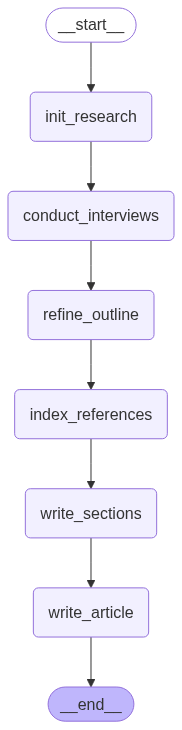

In [35]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    sections: List[WikiSection]
    article: str

import asyncio

async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }

def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{message.name}: {message.content}" for message in messages)
    return f"Conversation with {interview_state['editor'].name}\n\n"+convo


async def refine_outline(state:ResearchState):
    convos= "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state['interview_results']
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke({
        'topic': state['topic'],
        'old_outline': state['outline'].as_str,
        "conversations": convos
    })
    return {**state, "outline": updated_outline}

async def index_references(state:ResearchState):
    all_docs = []
    for interview_state in state['interview_results']:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state['references'].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state

async def write_sections(state:ResearchState):
    outline = state['outline']
    sections = await section_writer.abatch([
        {
            "outline": outline.as_str,
            "section": section.section_title,
            "topic": state['topic']
        }
        for section in outline.sections
    ])
    return {
        **state,
        "sections": sections,
    }
async def write_article(state:ResearchState):
    topic = state['topic']
    sections = state['sections']
    draft = "\n\n".join(section.as_str for section in sections)
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article
    }


builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()
from IPython.display import Image
Image(storm.get_graph().draw_mermaid_png())

In [ ]:
results = None
async for step in storm.astream({"topic":"Groq, NVIDIA, Llamma.cpp and the future of LLM Inference"}):
    name=next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    results = step[name]

from IPython.display import Markdown
article = results['article']
Markdown(article.replace("\n#", "\n##"))

init_research
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', sections=[Section(section_title='Introduction', description='Introduction to Large Language Model (LLM) inference and its challenges.', subs
conduct_interviews
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', sections=[Section(section_title='Introduction', description='Introduction to Large Language Model (LLM) inference and its challenges.', subs
refine_outline
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', sections=[Section(section_title='Introduction', description='Introduction to Large Language Model (LLM) inference and its challenges.', subs
index_references
--  {'topic': 'Groq,

```markdown
## LLM Inference Platforms: Groq, NVIDIA, Llama.cpp, and the Future

### Introduction

Large Language Models (LLMs) have emerged as a transformative technology, demonstrating remarkable capabilities in natural language understanding and generation. However, deploying these models for real-time applications presents significant computational challenges. This section provides an overview of LLMs, defines LLM inference, and discusses the challenges associated with it.

#### What are LLMs?

LLMs are deep learning models with a large number of parameters, trained on vast amounts of text data. They are capable of performing a wide range of tasks, including text generation, translation, question answering, and code generation. Examples include GPT-3, LLaMA, and BERT.

#### LLM Inference: Definition and Significance

LLM inference refers to the process of using a trained LLM to generate outputs for new inputs. It is the deployment phase where the model is used to make predictions or generate text in real-world applications. Efficient LLM inference is crucial for enabling interactive applications and services powered by these models.

#### Challenges in LLM Inference

LLM inference faces several challenges, including high latency, limited throughput, and substantial memory requirements. The computational intensity of LLMs demands specialized hardware and software optimization techniques to achieve acceptable performance. Memory bandwidth and power consumption also pose significant constraints.

### Groq and LLM Inference

Groq offers a unique approach to LLM inference with its Tensor Streaming Processor (TSP) architecture. Unlike traditional GPUs, Groq's architecture emphasizes deterministic data flow and high memory bandwidth, which are particularly well-suited for the demands of LLM inference.

#### Groq's Hardware Architecture

Groq's hardware architecture is centered around the Tensor Streaming Processor (TSP), now referred to as the Language Processing Unit (LPU). The LPU is designed for high computational throughput and low latency, crucial for LLM inference. A key feature is its deterministic data flow, which allows for predictable performance and efficient resource utilization. The architecture prioritizes high memory bandwidth to keep the processing units fed with data, minimizing bottlenecks. However, each chip has limited on-chip memory (200MB), requiring racks to run larger LLMs.

#### Groq's Software Stack and Optimization Techniques

Groq's software stack includes a compiler that plays a critical role in scheduling and resource allocation. The compiler optimizes the execution of LLMs on the TSP architecture, taking advantage of its deterministic nature. The deterministic programming model simplifies optimization and allows for predictable performance. Groq's architecture doesn't get faster for batch sizes >1.

#### Performance Benchmarks and Comparisons

Groq has demonstrated impressive performance benchmarks, particularly in terms of latency. A single Groq LPU card can outperform expensive cloud GPU instances on LLM serving. Groq's architecture shines in scenarios where low latency is paramount.

#### Power Efficiency and Thermal Characteristics

Groq's architecture is designed for power efficiency. By minimizing data movement and maximizing resource utilization, the TSP-based systems can achieve competitive performance per watt. The reduced need for over-provisioning for batch size contributes to power savings.

#### Handling Variability and Stochasticity

Groq addresses the variability and stochasticity of LLM inference workloads through its scheduling and resource allocation mechanisms. The deterministic nature of the TSP architecture allows for precise control over execution, mitigating the impact of variability.

### NVIDIA and LLM Inference

NVIDIA's approach to LLM inference leverages its powerful GPUs and a comprehensive software ecosystem. Their strategy centers around maximizing parallelism and providing developers with robust tools for optimization.

#### NVIDIA GPUs and LLM Inference

NVIDIA GPUs, particularly architectures like H100 and A100, are designed for massively parallel computation, making them well-suited for the demands of LLM inference. These GPUs contain thousands of cores that can simultaneously perform the matrix multiplications and other operations that are fundamental to deep learning. The high memory bandwidth and large memory capacity of NVIDIA GPUs also allow them to handle large models and datasets efficiently.

#### NVIDIA's Software Ecosystem and Optimization

NVIDIA's software ecosystem, including CUDA and TensorRT, provides developers with the tools to optimize LLMs for inference. CUDA is a parallel computing platform and programming model that allows developers to harness the power of NVIDIA GPUs for general-purpose computing. TensorRT is an SDK for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high throughput for deep learning applications.

The advantages of using CUDA and TensorRT include: broad hardware compatibility, mature software tools, and extensive community support. Challenges include: the complexity of CUDA programming and the need for specialized knowledge to optimize models for TensorRT.

#### Performance Benchmarks and Comparisons

NVIDIA GPUs offer high performance and scalability for LLM inference. Benchmarks consistently show that NVIDIA GPUs can deliver high throughput and low latency for a wide range of LLMs. However, power consumption can be a concern, especially for large models. The performance and power efficiency of NVIDIA GPUs vary depending on the specific model, the size of the LLM, and the optimization techniques used. According to a report on NextPlatform, when comparing against Groq's LPU, NVIDIA's GPUs can do an inference in one-tenth the time at one tenth the cost of generating the tokens. It takes the Nvidia GPU somewhere on the order of 10 joules to 30 joules to generate tokens in a response. [1]

#### Software Development and Tooling

Optimizing LLMs for inference on NVIDIA GPUs involves several steps, including: model quantization, graph optimization, and kernel fusion. NVIDIA provides a suite of tools and libraries to assist developers with these tasks. Key challenges include: balancing performance and accuracy, managing memory usage, and adapting to new model architectures. Advantages include: access to a wide range of pre-trained models and optimized kernels, and the ability to leverage NVIDIA's expertise in deep learning.

#### Scalability

NVIDIA's GPU architecture scales effectively using technologies like NVLink and NVSwitch for multi-GPU systems. NVLink provides high-bandwidth, low-latency interconnects between GPUs, allowing them to share data and coordinate computations efficiently. NVSwitch enables all-to-all communication between GPUs in a system. NVIDIA also offers mature software tools for distributed training and inference across clusters of GPUs, making it possible to scale LLM inference to handle large workloads.

### Llamma.cpp and Open-Source LLM Inference

Llamma.cpp has emerged as a significant player in the open-source LLM inference landscape, providing a platform for running large language models on a variety of hardware, including CPUs. It democratizes access to LLMs by enabling local inference, reducing reliance on proprietary hardware and cloud services.

#### Introduction to Llamma.cpp

Llamma.cpp is a project focused on enabling efficient inference of large language models (LLMs) using C++. Its primary goal is to make LLMs accessible to a wider audience by allowing them to run on consumer-grade hardware, including laptops and desktops, without requiring specialized GPUs. This is achieved through a combination of optimization techniques and support for various quantization methods.

#### Architecture and Implementation

Llamma.cpp is written in C++ for performance and portability. It leverages techniques like quantization (reducing the precision of weights and activations) to minimize memory footprint and computational requirements. The architecture is designed to be modular, allowing for easy integration of new models and hardware platforms. It supports various platforms, including x86, ARM, and Apple Silicon. The core implementation focuses on efficient matrix multiplication and other linear algebra operations crucial for LLM inference.

#### Performance and Limitations

Llamma.cpp's performance varies depending on the hardware and model used. While it may not match the throughput of high-end GPUs, it offers a viable option for local inference, especially for smaller models or when running on resource-constrained devices. Limitations include slower inference speeds compared to GPU-accelerated solutions and potential accuracy degradation due to quantization. However, ongoing development continuously improves its performance and expands its capabilities.

#### Comparison with Other Open-Source Solutions

Several other open-source LLM inference solutions exist, such as those based on ONNX Runtime or optimized for specific hardware architectures. Llamma.cpp distinguishes itself through its focus on simplicity, portability, and ease of use. It often serves as a reference implementation and a starting point for researchers and developers exploring LLM inference optimization techniques. Compared to some more complex solutions, Llamma.cpp is easier to set up and use, making it attractive to users with limited technical expertise.

#### Quantization Techniques

Llamma.cpp employs various quantization techniques to reduce the memory footprint and computational demands of LLMs. Quantization involves converting the floating-point weights and activations of a model to lower-precision integer representations (e.g., 8-bit or 4-bit integers). This reduces the model size and speeds up inference, but it can also lead to a loss of accuracy. The effectiveness and impact on accuracy of these quantization techniques can vary depending on the hardware platform. Groq's TSP, with its deterministic data flow, might exhibit different quantization behavior compared to NVIDIA GPUs, which rely on massively parallel architectures. Further research and experimentation are needed to fully understand these differences.

### Comparative Analysis

A comprehensive comparison of Groq, NVIDIA, and Llamma.cpp reveals distinct advantages and disadvantages across various parameters, including performance, cost, ease of use, and accessibility. Each platform caters to different needs and use cases, making a direct comparison complex but insightful.

#### Performance, Cost, Ease of Use, and Accessibility

When considering performance, Groq stands out for its low latency inference, particularly beneficial for real-time applications. NVIDIA GPUs, on the other hand, offer high throughput and scalability, making them suitable for large-scale deployments. Llamma.cpp provides a more accessible entry point for local inference, but its performance is generally lower compared to the other two, especially with larger models. In terms of cost, Llamma.cpp offers the most cost-effective solution as it leverages existing hardware. Groq's LPU cards can be expensive, but they offer a compelling performance per dollar for specific workloads. NVIDIA GPUs vary in price, with high-end models being a significant investment. Ease of use is another differentiating factor. NVIDIA boasts a mature software ecosystem with CUDA and TensorRT, providing extensive tools and libraries for developers. Llamma.cpp is relatively easy to set up and use, especially for those familiar with C++. Groq's software stack, while powerful, may require a steeper learning curve. Accessibility is also a key consideration. NVIDIA GPUs are widely available and supported by major cloud providers. Llamma.cpp can be run on a wide range of hardware, making it highly accessible. Groq's hardware is less readily available, potentially limiting its accessibility.

#### Strengths and Weaknesses in Different Use Cases

Groq excels in use cases demanding ultra-low latency, such as real-time language translation or interactive AI applications. Its deterministic data flow and high memory bandwidth make it well-suited for these scenarios. NVIDIA GPUs shine in applications requiring high throughput and scalability, such as large-scale language model serving or training. Their massively parallel architecture and mature software ecosystem provide the necessary tools for these tasks. Llamma.cpp is ideal for local inference and experimentation, allowing users to run LLMs on their own hardware without relying on cloud services. However, it may not be suitable for production environments with high performance requirements. A key weakness of Groq is the limited on-chip memory, necessitating racks of chips to run larger LLMs. NVIDIA's weakness includes underutilization if batch sizes are not optimized, leading to wasted power. Llamma.cpp's primary weakness is its performance ceiling compared to dedicated hardware solutions.

#### Power Efficiency Comparison

Groq's LPU is designed for power efficiency, particularly when running at its optimal batch size, avoiding the over-provisioning issues that can plague GPU deployments. NVIDIA GPUs, while powerful, can consume significant power, especially when not fully utilized. Llamma.cpp's power consumption depends on the underlying hardware, but it generally consumes less power than dedicated GPU or LPU solutions. The key architectural factors contributing to Groq's power efficiency include its deterministic data flow and elimination of external memory access bottlenecks. By minimizing data movement and maximizing on-chip computation, Groq reduces energy consumption. NVIDIA GPUs, on the other hand, rely on a more traditional architecture with external memory access, which can be a significant source of power consumption.

#### Software Stacks and Development Tools

NVIDIA's CUDA and TensorRT provide a rich set of tools and libraries for optimizing LLMs, along with extensive community support and a wide range of pre-trained models. Groq's software stack, while offering a deterministic programming model, may have a smaller community and fewer pre-trained models readily available. This can increase the initial effort required to deploy and optimize LLMs on Groq's platform. Llamma.cpp benefits from its simplicity and ease of use, but it may lack the advanced optimization features and extensive tooling available in NVIDIA's ecosystem. The choice of software stack and development tools depends on the specific requirements of the project, the available expertise, and the desired level of control over the optimization process.

### Future of LLM Inference

The field of LLM inference is rapidly evolving, driven by the increasing demand for faster, more efficient, and more accessible AI. Several emerging technologies and trends are poised to significantly impact the future of LLM inference, shaping the landscape for both hardware and software solutions.

#### Emerging Technologies and Their Impact

Several emerging technologies promise to revolutionize LLM inference.  **Specialized Hardware:**  Continued development of specialized hardware like Groq's LPU and other ASICs (Application-Specific Integrated Circuits) will likely lead to further performance gains and power efficiency improvements.  **Quantization and Pruning:** Advances in model compression techniques like quantization (reducing the precision of weights) and pruning (removing less important connections) will enable smaller, faster models that require less memory and compute.  **Novel Architectures:** Exploration of novel neural network architectures, such as Mixture of Experts (MoE), could lead to more efficient and scalable models.  **Near-Memory Computing:** Architectures that bring computation closer to memory can reduce data movement bottlenecks, a major factor in LLM inference latency.

#### Future Landscape and Predictions

The future of LLM inference is likely to be characterized by a few key trends.  **Increased Specialization:**  We can expect to see further specialization of hardware and software for LLM inference, with solutions tailored to specific model sizes, architectures, and deployment scenarios.  **Edge Inference:**  The ability to run LLMs on edge devices (e.g., smartphones, IoT devices) will become increasingly important, enabling real-time AI applications with low latency and enhanced privacy.  **Democratization of AI:**  Open-source solutions like Llama.cpp will continue to play a crucial role in democratizing access to LLMs, allowing individuals and smaller organizations to experiment with and deploy these models without relying on expensive proprietary platforms.  **Cloud vs. On-Premise:**  The balance between cloud-based and on-premise LLM inference will depend on factors such as cost, latency requirements, data security concerns, and regulatory constraints.  It's likely that both deployment models will coexist, with cloud solutions being favored for large-scale, general-purpose applications and on-premise solutions being preferred for latency-sensitive or data-private use cases.

#### Ethical and Environmental Implications

The increasing use of LLMs raises important ethical and environmental considerations.  **Energy Consumption:**  LLM inference can be energy-intensive, particularly when using large models and running them at scale. Groq's architecture, with its focus on efficiency, offers a potential advantage in reducing the carbon footprint of LLM deployments compared to traditional GPU-based solutions. Open-source solutions like Llama.cpp can also contribute to sustainability by enabling inference on less powerful hardware.  **Bias and Fairness:**  LLMs can perpetuate and amplify biases present in their training data, leading to unfair or discriminatory outcomes. It is crucial to carefully evaluate and mitigate these biases to ensure that LLMs are used responsibly.  **Accessibility:**  The cost and complexity of LLM inference can create barriers to access, potentially exacerbating existing inequalities. Efforts to democratize access to LLMs through open-source solutions and more efficient hardware are essential to ensure that the benefits of AI are shared broadly.

#### Security Implications

Security is a paramount concern in LLM inference.  **Malicious Code Injection:**  LLMs are vulnerable to prompt injection attacks, where malicious actors can manipulate the model's behavior by crafting carefully designed prompts. Robust input validation and sanitization techniques are needed to mitigate this risk.  **Data Breaches:**  LLMs can inadvertently leak sensitive information if they are not properly secured. Access control mechanisms, data encryption, and privacy-preserving techniques are essential to protect confidential data.  **Model Tampering:**  Adversaries could attempt to tamper with the LLM itself, either by modifying its weights or by injecting malicious code. Model integrity checks and secure deployment practices are needed to prevent such attacks. The choice of platform can also impact security. Open-source solutions like Llama.cpp offer greater transparency and control, but they also require more expertise to secure properly. Proprietary platforms like Groq and NVIDIA may offer more robust security features, but they also involve a greater degree of trust in the vendor.

### Conclusion

In conclusion, the landscape of LLM inference is rapidly evolving, with diverse platforms like Groq, NVIDIA, and Llamma.cpp offering distinct advantages and disadvantages. Groq's LPU-based architecture excels in low-latency inference due to its deterministic data flow and high memory bandwidth, making it suitable for real-time applications. NVIDIA's GPUs, with their massively parallel architecture and mature software ecosystem, provide high throughput and scalability, catering to large-scale deployments. Llamma.cpp, as an open-source solution, offers flexibility and accessibility, empowering researchers and developers to experiment with LLM inference on commodity hardware.

The choice of platform depends heavily on the specific use case, budget, and performance requirements. Groq shines in latency-sensitive applications, while NVIDIA dominates in throughput-demanding scenarios. Llamma.cpp provides a cost-effective and customizable solution for smaller-scale deployments and research purposes.

Looking ahead, emerging technologies like specialized AI accelerators and advanced quantization techniques promise to further optimize LLM inference. The future landscape will likely be shaped by a combination of hardware and software innovations, with a focus on improving efficiency, reducing costs, and expanding accessibility. Ethical and environmental considerations will also play a crucial role in shaping the development and deployment of LLM inference platforms, encouraging the adoption of energy-efficient solutions and responsible AI practices. Security considerations around malicious code injection and data breaches will also continue to be paramount.

Ultimately, the ongoing advancements in LLM inference will pave the way for more widespread adoption of AI-powered applications across various industries, transforming how we interact with technology and solve complex problems.

### References

[1]  "Groq Says It Can Deploy 1 Million AI Inference Chips in Two Years." *The Next Platform*, 27 Nov. 2023, https://www.nextplatform.com/2023/11/27/groq-says-it-can-deploy-1-million-ai-inference-chips-in-two-years/.
```

In [44]:
from IPython.display import Markdown
article = results[name]['article']
Markdown(article.replace("\n#", "\n##"))

```markdown
## LLM Inference: Groq, NVIDIA, Llamma.cpp, and the Future

### Introduction

Large Language Models (LLMs) have emerged as powerful tools in artificial intelligence, capable of generating human-quality text, translating languages, and answering complex questions. However, efficiently deploying these models for real-time applications presents significant challenges. This section introduces the concept of LLM inference, its importance, and the hurdles that must be overcome to make LLMs accessible and practical.

#### What are LLMs?

LLMs are deep learning models with a large number of parameters, trained on vast amounts of text data. They leverage transformer architectures to understand and generate text, enabling applications such as chatbots, content creation, and code generation.

#### LLM Inference: Definition and Significance

LLM inference refers to the process of using a trained LLM to generate predictions or outputs for new input data. It is the crucial step that allows us to utilize the knowledge and capabilities learned by the model during training. Efficient inference is essential for deploying LLMs in real-world applications, as it directly impacts the user experience and the cost of serving the model.

#### Challenges in LLM Inference

LLM inference faces several challenges, including high computational costs, memory limitations, and latency requirements. The sheer size of LLMs, with billions or even trillions of parameters, demands significant computational resources. Minimizing latency, the time it takes to generate a response, is crucial for interactive applications. Furthermore, memory constraints can limit the size of models that can be deployed on a given hardware platform. Throughput, or the number of requests that can be processed per unit of time, is also a key consideration for serving a large number of users.

#### Ethical Considerations and Societal Impact

The increasing capabilities and deployment of AI accelerators and LLMs raise important ethical considerations. Accessibility is paramount; ensuring that the benefits of these technologies are available to a wide range of users and developers is crucial to avoid exacerbating existing inequalities. Bias in training data can lead to LLMs generating discriminatory or unfair outputs, highlighting the need for careful data curation and model evaluation. The environmental impact of training and deploying large models, particularly in terms of energy consumption, must also be addressed to promote sustainable AI development.

### Groq and LLM Inference

Groq is emerging as a significant player in the LLM inference landscape with its Tensor Streaming Processor (TSP) architecture. Unlike traditional GPUs, Groq's architecture is designed from the ground up for the sequential nature of language processing, potentially offering advantages in latency and throughput for LLM inference. Groq's solution focuses on providing high throughput, low latency, and lower cost for LLM inference compared to NVIDIA GPUs.

Groq's API streamlines integration, allowing developers to use its LPU and open-source models in their applications without complex hardware setup or LLM expertise. The company offers several LLM models through its API, catering to diverse needs. Groq's LPU provides configurable hardware components, allowing developers to fine-tune the architecture for specific LLM models and tasks, optimizing performance and resource utilization.

#### Groq's Hardware Architecture: Tensor Streaming Processor (TSP)

Groq's hardware architecture centers around the Tensor Streaming Processor (TSP). The TSP is designed to minimize data movement and maximize computational density, which are critical for LLM inference. The architecture incorporates a large amount of SRAM memory close to the compute units, reducing the need to access external memory and improving performance. This design choice contrasts with GPUs, which often rely on large, fast main memory but can be bottlenecked by memory access latency. Groq's architecture is wide, relatively slow, and low power, achieving high performance through massive parallelism across many units.

#### Groq's Software Stack and Optimization Techniques

Groq offers a software stack that includes a compiler designed for deterministic execution. This compiler plays a crucial role in optimizing LLMs for the TSP architecture. The software stack aims to simplify the deployment of LLMs on Groq's hardware, abstracting away the complexities of the underlying hardware.

#### Performance Benchmarks and Comparisons

Groq has demonstrated impressive performance benchmarks, particularly in latency. Benchmarks show Groq's LPU Inference Engine achieving significantly faster inference speeds compared to NVIDIA GPUs for certain LLM workloads [2]. Groq's architecture shines in scenarios where low latency is paramount. For example, in LLAMA 2 benchmarks, Groq has shown the ability to process tokens at a significantly faster rate than NVIDIA GPUs [2]. However, it's important to consider the specific model, batch size, and inference scenario when comparing performance, as GPUs may excel in different situations.

#### Limitations of Groq's LPU Technology

Despite its strengths, Groq's LPU technology has limitations. The software ecosystem surrounding Groq's hardware is still maturing compared to NVIDIA's well-established CUDA ecosystem. Power efficiency is another consideration, as the 14nm chip may face challenges compared to newer GPU architectures in terms of power consumption per inference. Further, while Groq's architecture excels in certain LLM inference tasks, its applicability to other AI workloads may be more limited than that of general-purpose GPUs.

#### Groq's TruePoint Quantization

Groq utilizes a proprietary quantization technique called "TruePoint." Quantization is a method of reducing the precision of numerical representations in a model (e.g., from 32-bit floating point to 8-bit integer), which can significantly improve performance and reduce memory footprint. TruePoint aims to minimize the accuracy loss associated with quantization, allowing Groq to achieve high performance without sacrificing model quality [0]. The specifics of the TruePoint technique are not widely publicized, but it is a key component of Groq's overall optimization strategy.

### NVIDIA and LLM Inference

#### NVIDIA GPUs and LLM Inference: Ampere/Hopper Architecture

NVIDIA's hardware (GPUs) play a significant role in LLM inference, particularly the Ampere and Hopper architectures. These architectures incorporate Tensor Cores (Ampere) and Matrix Cores (Hopper), specialized hardware units designed to accelerate matrix multiplication operations, which are fundamental to deep learning and LLM inference. The Hopper architecture further enhances performance with features like the Transformer Engine, specifically optimized for transformer models.

#### NVIDIA's Software Ecosystem and Optimization

NVIDIA's software ecosystem, including CUDA and TensorRT, provides a comprehensive suite of tools for optimizing LLMs for inference. CUDA is a parallel computing platform and programming model that allows developers to leverage the power of NVIDIA GPUs. TensorRT is an SDK for high-performance deep learning inference, optimizing models for deployment in production environments. Optimization techniques include tensor parallelism (distributing tensors across multiple GPUs), pipeline parallelism (dividing the model into stages and processing them concurrently), and model quantization (reducing the precision of model weights to improve performance and reduce memory footprint).

#### Performance Benchmarks and Comparisons

NVIDIA GPUs consistently demonstrate strong performance in LLM inference benchmarks. The exact performance depends on the specific GPU model, LLM architecture, batch size, and optimization techniques used. NVIDIA provides detailed performance benchmarks for various LLMs and inference scenarios on its website and in technical publications. These benchmarks often compare NVIDIA GPUs against other platforms, highlighting their advantages in terms of latency and throughput.

#### NVIDIA's Quantization Methods (PTQ, QAT)

NVIDIA supports various quantization methods, including post-training quantization (PTQ) and quantization-aware training (QAT). PTQ involves quantizing a pre-trained model without further training, offering a simple and fast way to improve performance. QAT, on the other hand, involves training the model with quantization in mind, leading to better accuracy compared to PTQ but requiring more computational resources. Both methods offer trade-offs between accuracy and efficiency, allowing developers to choose the best approach for their specific needs.

### Llamma.cpp and Open-Source LLM Inference

Llamma.cpp has emerged as a significant player in the open-source LLM inference landscape. It distinguishes itself by enabling efficient inference on commodity hardware, making LLMs more accessible to a wider audience.

#### Introduction to Llamma.cpp

Llamma.cpp is a project focused on running large language models (LLMs) with minimal hardware requirements. Its primary goal is to enable efficient LLM inference on readily available consumer hardware, such as CPUs and lower-end GPUs, without relying on specialized AI accelerators. This makes it possible for individuals and smaller organizations to experiment with and deploy LLMs without significant capital investment.

#### Architecture and Implementation

Llamma.cpp achieves its efficiency through a combination of techniques. It's written in C++, allowing for low-level optimization and direct hardware control. Key implementation details include:

*   **Quantization:** Llamma.cpp heavily utilizes quantization techniques, reducing the precision of model weights (e.g., 4-bit, 2-bit quantization). This significantly reduces memory footprint and computational requirements, enabling models to run on devices with limited resources.
*   **Optimization Strategies:** The library employs various optimization strategies, such as kernel fusion and optimized matrix multiplication routines, to maximize performance on target hardware.
*   **CPU and GPU Support:** Llamma.cpp supports both CPU and GPU execution, allowing users to choose the best option based on their hardware configuration. GPU support is often implemented via libraries like CUDA or Metal.

#### Performance and Limitations

The performance of Llamma.cpp depends heavily on the model size, quantization level, and hardware used. While it enables inference on resource-constrained devices, there are trade-offs:

*   **Accuracy vs. Efficiency:** Lower precision quantization (e.g., 2-bit) leads to greater efficiency but can also reduce model accuracy. Users must carefully balance these factors.
*   **Hardware Requirements:** While Llamma.cpp can run on CPUs, performance is generally better on GPUs, especially those with sufficient VRAM to hold the quantized model.
*   **Limitations:** Very large models may still be challenging to run efficiently on low-end hardware, even with aggressive quantization.

#### Comparison with Other Open-Source Solutions

Llamma.cpp is not the only open-source LLM inference solution available. Other notable projects include:

*   **Hugging Face Transformers:** A comprehensive library that provides tools for loading, running, and training various LLMs. While not as focused on extreme efficiency as Llamma.cpp, it offers a wider range of features and model support.
*   **ONNX Runtime:** A cross-platform inference engine that supports a variety of hardware backends. It can be used to run LLMs in ONNX format.

Llamma.cpp distinguishes itself with its focus on minimal dependencies, ease of use, and aggressive optimization for low-resource environments.

### Comparative Analysis

Groq, NVIDIA, and Llamma.cpp each offer distinct advantages and disadvantages for LLM inference, making their suitability highly dependent on the specific use case and priorities. This section provides a comparative analysis based on several key factors.

#### Performance, Cost, Ease of Use, Accessibility, and Power Consumption

When comparing performance, cost, ease of use, accessibility, and power consumption, the landscape is complex. Groq's LPU-based solution excels in low-latency inference, particularly for smaller models, due to its deterministic execution and high memory bandwidth. Benchmarks have shown Groq's LPU Inference Engine achieving impressive speeds, potentially outperforming NVIDIA GPUs in certain LLM inference tasks [2]. However, Groq's technology may face challenges with larger models and batch processing where GPUs traditionally shine.

NVIDIA GPUs offer a more versatile solution, with a wide range of options catering to different performance and cost requirements. Their mature software ecosystem (CUDA, TensorRT) and extensive optimization techniques provide flexibility and high throughput, especially for large models and batched inference. However, GPUs can be power-hungry and may require significant capital investment.

Llamma.cpp stands out as an accessible and cost-effective open-source solution, enabling LLM inference on commodity hardware. While it may not match the raw performance of Groq or NVIDIA, its ability to run on CPUs and lower-end GPUs makes it ideal for local development, research, and edge deployment where cost and accessibility are paramount. Llamma.cpp's quantization techniques allow for efficient inference even on resource-constrained devices, but this often comes with accuracy trade-offs.

#### Strengths and Weaknesses in Different Use Cases

Groq's strength lies in applications demanding ultra-low latency, such as real-time conversational AI or interactive applications. Its deterministic execution is also valuable in scenarios where predictable performance is critical. However, its limitations in software ecosystem maturity and power efficiency may hinder its adoption in certain areas.

NVIDIA GPUs are well-suited for a broad range of use cases, from cloud deployment and high-throughput inference to research and development. Their versatility, extensive software support, and powerful hardware make them a popular choice for demanding LLM applications. However, the high cost of high-end GPUs can be a barrier to entry for some users.

Llamma.cpp shines in edge computing scenarios, local development, and research projects where accessibility and cost are key considerations. Its ability to run on commodity hardware makes it ideal for prototyping, experimentation, and deployment on resource-constrained devices. However, its performance limitations may restrict its use in high-demand production environments.

#### Impact of Market Concentration and Capital Investment on Bias

The concentration of market power and capital investment in the hands of a few large players like NVIDIA can exacerbate bias in LLM inference. These companies have significant influence over the development and deployment of AI hardware and software, which can lead to biases being embedded in the technology. For example, if the training data used to optimize LLMs is biased, the resulting models will likely perpetuate those biases. Furthermore, the high cost of entry into the AI hardware market can limit competition and innovation, potentially leading to a lack of diversity in the types of AI systems that are developed and deployed. Open-source initiatives like Llamma.cpp can help to mitigate these biases by providing alternative platforms for LLM inference that are more accessible and transparent. However, these initiatives often lack the resources and capital investment of larger companies, which can limit their impact.

### Future of LLM Inference

The future of LLM inference is poised for significant advancements, driven by the increasing demand for faster, more efficient, and accessible AI. Emerging technologies and evolving market dynamics are shaping the landscape, pushing the boundaries of what's possible in LLM deployment and utilization.

#### Emerging Technologies and Their Impact

Several emerging technologies hold the potential to revolutionize LLM inference. New hardware architectures, such as neuromorphic computing and optical computing, promise significant improvements in energy efficiency and processing speed. Quantization techniques are also evolving, with research focusing on minimizing accuracy loss while maximizing compression. Model compression methods like pruning and distillation are becoming more sophisticated, enabling smaller, faster models suitable for edge deployment.

#### Future Landscape of LLM Inference

The future landscape of LLM inference hardware and software will likely be characterized by a diverse ecosystem catering to different user segments. High-performance cloud solutions will continue to dominate for large-scale deployments, while specialized edge devices will enable real-time inference in constrained environments. The balance between performance, cost, and power consumption will be a key consideration, with vendors offering tailored solutions for specific needs. We can expect to see more integration of LLM inference capabilities directly into consumer devices, such as smartphones and laptops.

#### Evolution of LLM Accessibility

LLM accessibility is expected to increase significantly over the next 3-5 years. Open-source initiatives like Llamma.cpp are democratizing access to LLMs, enabling individuals and smaller organizations to experiment with and deploy these models on commodity hardware. Cloud-based inference services are also becoming more affordable and user-friendly, lowering the barrier to entry for businesses of all sizes. As hardware and software become more efficient, LLMs will be increasingly accessible to a wider range of users, fostering innovation and driving adoption across various industries.

### Conclusion

In conclusion, the landscape of LLM inference is rapidly evolving, with diverse approaches vying for dominance. Groq's TSP architecture offers impressive low-latency inference, particularly for smaller models, but faces challenges in software ecosystem maturity and power efficiency. NVIDIA's GPUs, backed by a robust software ecosystem and extensive optimization libraries, remain a strong contender, offering a balance of performance and versatility. Llamma.cpp provides an accessible open-source solution, enabling LLM inference on commodity hardware with remarkable efficiency, albeit with trade-offs in accuracy and model size. The choice of platform depends heavily on the specific use case, budget, and performance requirements. As emerging technologies continue to advance, the future of LLM inference will likely be shaped by innovations in hardware architectures, quantization techniques, and model compression methods, ultimately driving greater accessibility and efficiency across various user segments.

### References

[0] https://medium.com/@laowang_journey/comparing-ai-hardware-architectures-sambanova-groq-cerebras-vs-nvidia-gpus-broadcom-asics-2327631c468e
[1] https://www.nextplatform.com/2023/11/27/groq-says-it-can-deploy-1-million-ai-inference-chips-in-two-years/
[2] https://www.reddit.com/r/LocalLLaMA/comments/1avz9hk/the_groq_chip_is_faster_than_nvidia_13x_faster/
[3] https://promptengineering.org/groqs-lpu-advancing-llm-inference-efficiency/
```

```markdown
## LLM Inference Platforms: Groq, NVIDIA, Llama.cpp, and the Future

### Introduction

Large Language Models (LLMs) have emerged as a transformative technology, demonstrating remarkable capabilities in natural language understanding and generation. However, deploying these models for real-time applications presents significant computational challenges. This section provides an overview of LLMs, defines LLM inference, and discusses the challenges associated with it.

#### What are LLMs?

LLMs are deep learning models with a large number of parameters, trained on vast amounts of text data. They are capable of performing a wide range of tasks, including text generation, translation, question answering, and code generation. Examples include GPT-3, LLaMA, and BERT.

#### LLM Inference: Definition and Significance

LLM inference refers to the process of using a trained LLM to generate outputs for new inputs. It is the deployment phase where the model is used to make predictions or generate text in real-world applications. Efficient LLM inference is crucial for enabling interactive applications and services powered by these models.

#### Challenges in LLM Inference

LLM inference faces several challenges, including high latency, limited throughput, and substantial memory requirements. The computational intensity of LLMs demands specialized hardware and software optimization techniques to achieve acceptable performance. Memory bandwidth and power consumption also pose significant constraints.

### Groq and LLM Inference

Groq offers a unique approach to LLM inference with its Tensor Streaming Processor (TSP) architecture. Unlike traditional GPUs, Groq's architecture emphasizes deterministic data flow and high memory bandwidth, which are particularly well-suited for the demands of LLM inference.

#### Groq's Hardware Architecture

Groq's hardware architecture is centered around the Tensor Streaming Processor (TSP), now referred to as the Language Processing Unit (LPU). The LPU is designed for high computational throughput and low latency, crucial for LLM inference. A key feature is its deterministic data flow, which allows for predictable performance and efficient resource utilization. The architecture prioritizes high memory bandwidth to keep the processing units fed with data, minimizing bottlenecks. However, each chip has limited on-chip memory (200MB), requiring racks to run larger LLMs.

#### Groq's Software Stack and Optimization Techniques

Groq's software stack includes a compiler that plays a critical role in scheduling and resource allocation. The compiler optimizes the execution of LLMs on the TSP architecture, taking advantage of its deterministic nature. The deterministic programming model simplifies optimization and allows for predictable performance. Groq's architecture doesn't get faster for batch sizes >1.

#### Performance Benchmarks and Comparisons

Groq has demonstrated impressive performance benchmarks, particularly in terms of latency. A single Groq LPU card can outperform expensive cloud GPU instances on LLM serving. Groq's architecture shines in scenarios where low latency is paramount.

#### Power Efficiency and Thermal Characteristics

Groq's architecture is designed for power efficiency. By minimizing data movement and maximizing resource utilization, the TSP-based systems can achieve competitive performance per watt. The reduced need for over-provisioning for batch size contributes to power savings.

#### Handling Variability and Stochasticity

Groq addresses the variability and stochasticity of LLM inference workloads through its scheduling and resource allocation mechanisms. The deterministic nature of the TSP architecture allows for precise control over execution, mitigating the impact of variability.

### NVIDIA and LLM Inference

NVIDIA's approach to LLM inference leverages its powerful GPUs and a comprehensive software ecosystem. Their strategy centers around maximizing parallelism and providing developers with robust tools for optimization.

#### NVIDIA GPUs and LLM Inference

NVIDIA GPUs, particularly architectures like H100 and A100, are designed for massively parallel computation, making them well-suited for the demands of LLM inference. These GPUs contain thousands of cores that can simultaneously perform the matrix multiplications and other operations that are fundamental to deep learning. The high memory bandwidth and large memory capacity of NVIDIA GPUs also allow them to handle large models and datasets efficiently.

#### NVIDIA's Software Ecosystem and Optimization

NVIDIA's software ecosystem, including CUDA and TensorRT, provides developers with the tools to optimize LLMs for inference. CUDA is a parallel computing platform and programming model that allows developers to harness the power of NVIDIA GPUs for general-purpose computing. TensorRT is an SDK for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high throughput for deep learning applications.

The advantages of using CUDA and TensorRT include: broad hardware compatibility, mature software tools, and extensive community support. Challenges include: the complexity of CUDA programming and the need for specialized knowledge to optimize models for TensorRT.

#### Performance Benchmarks and Comparisons

NVIDIA GPUs offer high performance and scalability for LLM inference. Benchmarks consistently show that NVIDIA GPUs can deliver high throughput and low latency for a wide range of LLMs. However, power consumption can be a concern, especially for large models. The performance and power efficiency of NVIDIA GPUs vary depending on the specific model, the size of the LLM, and the optimization techniques used. According to a report on NextPlatform, when comparing against Groq's LPU, NVIDIA's GPUs can do an inference in one-tenth the time at one tenth the cost of generating the tokens. It takes the Nvidia GPU somewhere on the order of 10 joules to 30 joules to generate tokens in a response. [1]

#### Software Development and Tooling

Optimizing LLMs for inference on NVIDIA GPUs involves several steps, including: model quantization, graph optimization, and kernel fusion. NVIDIA provides a suite of tools and libraries to assist developers with these tasks. Key challenges include: balancing performance and accuracy, managing memory usage, and adapting to new model architectures. Advantages include: access to a wide range of pre-trained models and optimized kernels, and the ability to leverage NVIDIA's expertise in deep learning.

#### Scalability

NVIDIA's GPU architecture scales effectively using technologies like NVLink and NVSwitch for multi-GPU systems. NVLink provides high-bandwidth, low-latency interconnects between GPUs, allowing them to share data and coordinate computations efficiently. NVSwitch enables all-to-all communication between GPUs in a system. NVIDIA also offers mature software tools for distributed training and inference across clusters of GPUs, making it possible to scale LLM inference to handle large workloads.

### Llamma.cpp and Open-Source LLM Inference

Llamma.cpp has emerged as a significant player in the open-source LLM inference landscape, providing a platform for running large language models on a variety of hardware, including CPUs. It democratizes access to LLMs by enabling local inference, reducing reliance on proprietary hardware and cloud services.

#### Introduction to Llamma.cpp

Llamma.cpp is a project focused on enabling efficient inference of large language models (LLMs) using C++. Its primary goal is to make LLMs accessible to a wider audience by allowing them to run on consumer-grade hardware, including laptops and desktops, without requiring specialized GPUs. This is achieved through a combination of optimization techniques and support for various quantization methods.

#### Architecture and Implementation

Llamma.cpp is written in C++ for performance and portability. It leverages techniques like quantization (reducing the precision of weights and activations) to minimize memory footprint and computational requirements. The architecture is designed to be modular, allowing for easy integration of new models and hardware platforms. It supports various platforms, including x86, ARM, and Apple Silicon. The core implementation focuses on efficient matrix multiplication and other linear algebra operations crucial for LLM inference.

#### Performance and Limitations

Llamma.cpp's performance varies depending on the hardware and model used. While it may not match the throughput of high-end GPUs, it offers a viable option for local inference, especially for smaller models or when running on resource-constrained devices. Limitations include slower inference speeds compared to GPU-accelerated solutions and potential accuracy degradation due to quantization. However, ongoing development continuously improves its performance and expands its capabilities.

#### Comparison with Other Open-Source Solutions

Several other open-source LLM inference solutions exist, such as those based on ONNX Runtime or optimized for specific hardware architectures. Llamma.cpp distinguishes itself through its focus on simplicity, portability, and ease of use. It often serves as a reference implementation and a starting point for researchers and developers exploring LLM inference optimization techniques. Compared to some more complex solutions, Llamma.cpp is easier to set up and use, making it attractive to users with limited technical expertise.

#### Quantization Techniques

Llamma.cpp employs various quantization techniques to reduce the memory footprint and computational demands of LLMs. Quantization involves converting the floating-point weights and activations of a model to lower-precision integer representations (e.g., 8-bit or 4-bit integers). This reduces the model size and speeds up inference, but it can also lead to a loss of accuracy. The effectiveness and impact on accuracy of these quantization techniques can vary depending on the hardware platform. Groq's TSP, with its deterministic data flow, might exhibit different quantization behavior compared to NVIDIA GPUs, which rely on massively parallel architectures. Further research and experimentation are needed to fully understand these differences.

### Comparative Analysis

A comprehensive comparison of Groq, NVIDIA, and Llamma.cpp reveals distinct advantages and disadvantages across various parameters, including performance, cost, ease of use, and accessibility. Each platform caters to different needs and use cases, making a direct comparison complex but insightful.

#### Performance, Cost, Ease of Use, and Accessibility

When considering performance, Groq stands out for its low latency inference, particularly beneficial for real-time applications. NVIDIA GPUs, on the other hand, offer high throughput and scalability, making them suitable for large-scale deployments. Llamma.cpp provides a more accessible entry point for local inference, but its performance is generally lower compared to the other two, especially with larger models. In terms of cost, Llamma.cpp offers the most cost-effective solution as it leverages existing hardware. Groq's LPU cards can be expensive, but they offer a compelling performance per dollar for specific workloads. NVIDIA GPUs vary in price, with high-end models being a significant investment. Ease of use is another differentiating factor. NVIDIA boasts a mature software ecosystem with CUDA and TensorRT, providing extensive tools and libraries for developers. Llamma.cpp is relatively easy to set up and use, especially for those familiar with C++. Groq's software stack, while powerful, may require a steeper learning curve. Accessibility is also a key consideration. NVIDIA GPUs are widely available and supported by major cloud providers. Llamma.cpp can be run on a wide range of hardware, making it highly accessible. Groq's hardware is less readily available, potentially limiting its accessibility.

#### Strengths and Weaknesses in Different Use Cases

Groq excels in use cases demanding ultra-low latency, such as real-time language translation or interactive AI applications. Its deterministic data flow and high memory bandwidth make it well-suited for these scenarios. NVIDIA GPUs shine in applications requiring high throughput and scalability, such as large-scale language model serving or training. Their massively parallel architecture and mature software ecosystem provide the necessary tools for these tasks. Llamma.cpp is ideal for local inference and experimentation, allowing users to run LLMs on their own hardware without relying on cloud services. However, it may not be suitable for production environments with high performance requirements. A key weakness of Groq is the limited on-chip memory, necessitating racks of chips to run larger LLMs. NVIDIA's weakness includes underutilization if batch sizes are not optimized, leading to wasted power. Llamma.cpp's primary weakness is its performance ceiling compared to dedicated hardware solutions.

#### Power Efficiency Comparison

Groq's LPU is designed for power efficiency, particularly when running at its optimal batch size, avoiding the over-provisioning issues that can plague GPU deployments. NVIDIA GPUs, while powerful, can consume significant power, especially when not fully utilized. Llamma.cpp's power consumption depends on the underlying hardware, but it generally consumes less power than dedicated GPU or LPU solutions. The key architectural factors contributing to Groq's power efficiency include its deterministic data flow and elimination of external memory access bottlenecks. By minimizing data movement and maximizing on-chip computation, Groq reduces energy consumption. NVIDIA GPUs, on the other hand, rely on a more traditional architecture with external memory access, which can be a significant source of power consumption.

#### Software Stacks and Development Tools

NVIDIA's CUDA and TensorRT provide a rich set of tools and libraries for optimizing LLMs, along with extensive community support and a wide range of pre-trained models. Groq's software stack, while offering a deterministic programming model, may have a smaller community and fewer pre-trained models readily available. This can increase the initial effort required to deploy and optimize LLMs on Groq's platform. Llamma.cpp benefits from its simplicity and ease of use, but it may lack the advanced optimization features and extensive tooling available in NVIDIA's ecosystem. The choice of software stack and development tools depends on the specific requirements of the project, the available expertise, and the desired level of control over the optimization process.

### Future of LLM Inference

The field of LLM inference is rapidly evolving, driven by the increasing demand for faster, more efficient, and more accessible AI. Several emerging technologies and trends are poised to significantly impact the future of LLM inference, shaping the landscape for both hardware and software solutions.

#### Emerging Technologies and Their Impact

Several emerging technologies promise to revolutionize LLM inference.  **Specialized Hardware:**  Continued development of specialized hardware like Groq's LPU and other ASICs (Application-Specific Integrated Circuits) will likely lead to further performance gains and power efficiency improvements.  **Quantization and Pruning:** Advances in model compression techniques like quantization (reducing the precision of weights) and pruning (removing less important connections) will enable smaller, faster models that require less memory and compute.  **Novel Architectures:** Exploration of novel neural network architectures, such as Mixture of Experts (MoE), could lead to more efficient and scalable models.  **Near-Memory Computing:** Architectures that bring computation closer to memory can reduce data movement bottlenecks, a major factor in LLM inference latency.

#### Future Landscape and Predictions

The future of LLM inference is likely to be characterized by a few key trends.  **Increased Specialization:**  We can expect to see further specialization of hardware and software for LLM inference, with solutions tailored to specific model sizes, architectures, and deployment scenarios.  **Edge Inference:**  The ability to run LLMs on edge devices (e.g., smartphones, IoT devices) will become increasingly important, enabling real-time AI applications with low latency and enhanced privacy.  **Democratization of AI:**  Open-source solutions like Llama.cpp will continue to play a crucial role in democratizing access to LLMs, allowing individuals and smaller organizations to experiment with and deploy these models without relying on expensive proprietary platforms.  **Cloud vs. On-Premise:**  The balance between cloud-based and on-premise LLM inference will depend on factors such as cost, latency requirements, data security concerns, and regulatory constraints.  It's likely that both deployment models will coexist, with cloud solutions being favored for large-scale, general-purpose applications and on-premise solutions being preferred for latency-sensitive or data-private use cases.

#### Ethical and Environmental Implications

The increasing use of LLMs raises important ethical and environmental considerations.  **Energy Consumption:**  LLM inference can be energy-intensive, particularly when using large models and running them at scale. Groq's architecture, with its focus on efficiency, offers a potential advantage in reducing the carbon footprint of LLM deployments compared to traditional GPU-based solutions. Open-source solutions like Llama.cpp can also contribute to sustainability by enabling inference on less powerful hardware.  **Bias and Fairness:**  LLMs can perpetuate and amplify biases present in their training data, leading to unfair or discriminatory outcomes. It is crucial to carefully evaluate and mitigate these biases to ensure that LLMs are used responsibly.  **Accessibility:**  The cost and complexity of LLM inference can create barriers to access, potentially exacerbating existing inequalities. Efforts to democratize access to LLMs through open-source solutions and more efficient hardware are essential to ensure that the benefits of AI are shared broadly.

#### Security Implications

Security is a paramount concern in LLM inference.  **Malicious Code Injection:**  LLMs are vulnerable to prompt injection attacks, where malicious actors can manipulate the model's behavior by crafting carefully designed prompts. Robust input validation and sanitization techniques are needed to mitigate this risk.  **Data Breaches:**  LLMs can inadvertently leak sensitive information if they are not properly secured. Access control mechanisms, data encryption, and privacy-preserving techniques are essential to protect confidential data.  **Model Tampering:**  Adversaries could attempt to tamper with the LLM itself, either by modifying its weights or by injecting malicious code. Model integrity checks and secure deployment practices are needed to prevent such attacks. The choice of platform can also impact security. Open-source solutions like Llama.cpp offer greater transparency and control, but they also require more expertise to secure properly. Proprietary platforms like Groq and NVIDIA may offer more robust security features, but they also involve a greater degree of trust in the vendor.

### Conclusion

In conclusion, the landscape of LLM inference is rapidly evolving, with diverse platforms like Groq, NVIDIA, and Llamma.cpp offering distinct advantages and disadvantages. Groq's LPU-based architecture excels in low-latency inference due to its deterministic data flow and high memory bandwidth, making it suitable for real-time applications. NVIDIA's GPUs, with their massively parallel architecture and mature software ecosystem, provide high throughput and scalability, catering to large-scale deployments. Llamma.cpp, as an open-source solution, offers flexibility and accessibility, empowering researchers and developers to experiment with LLM inference on commodity hardware.

The choice of platform depends heavily on the specific use case, budget, and performance requirements. Groq shines in latency-sensitive applications, while NVIDIA dominates in throughput-demanding scenarios. Llamma.cpp provides a cost-effective and customizable solution for smaller-scale deployments and research purposes.

Looking ahead, emerging technologies like specialized AI accelerators and advanced quantization techniques promise to further optimize LLM inference. The future landscape will likely be shaped by a combination of hardware and software innovations, with a focus on improving efficiency, reducing costs, and expanding accessibility. Ethical and environmental considerations will also play a crucial role in shaping the development and deployment of LLM inference platforms, encouraging the adoption of energy-efficient solutions and responsible AI practices. Security considerations around malicious code injection and data breaches will also continue to be paramount.

Ultimately, the ongoing advancements in LLM inference will pave the way for more widespread adoption of AI-powered applications across various industries, transforming how we interact with technology and solve complex problems.

### References

[1]  "Groq Says It Can Deploy 1 Million AI Inference Chips in Two Years." *The Next Platform*, 27 Nov. 2023, https://www.nextplatform.com/2023/11/27/groq-says-it-can-deploy-1-million-ai-inference-chips-in-two-years/.
```